In [1]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward, ActuatedMassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

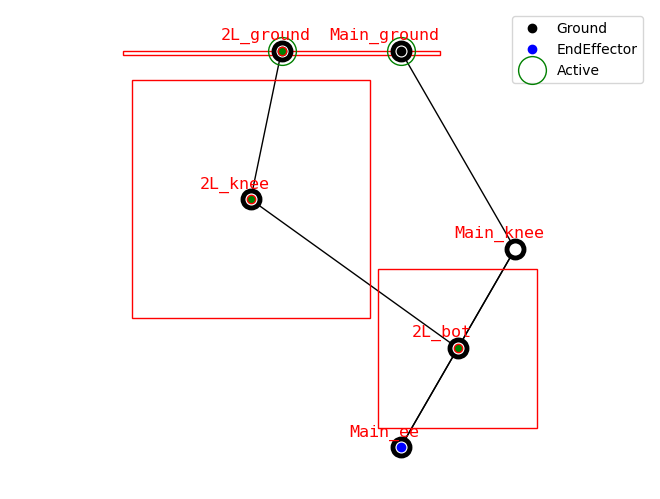

In [2]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[0]

actuator = TMotor_AK10_9()

thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

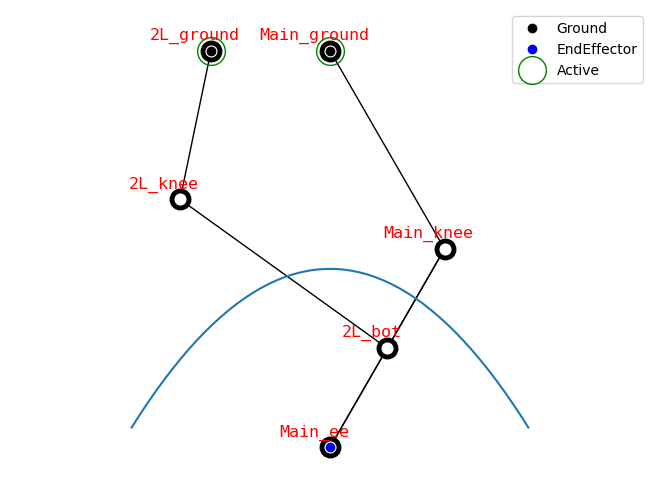

In [3]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -0.95], step_height= 0.4, step_width=1,n_points=50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1), (MassReward(mass_key="MASS"), 1), (ActuatedMassReward(mass_key="Actuated_Mass"),1)]

step_trajectories = [ground_symmetric_step]

rewards_and_trajectories = [(rewards_step, step_trajectories)]

draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

In [4]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])

Best trajectory id: 0 partial rewards at best trajectory: [0, 13.86465390974264, -3.6733657624087326, -2.6990614]


In [5]:
actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])

Best trajectory id: 0 partial rewards at best trajectory: [0, 2.615515026391314, -3.6733657624087326, -2.651631]


Change in mass of the actuator do not change mass criterion, but the inertia is changed.

In [6]:
graph, constrain_dict = all_graphs[1]
actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])

Best trajectory id: 0 partial rewards at best trajectory: [0, 15.045993147567302, -4.41732764610808, -2.0257275]


In [7]:
actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])

Best trajectory id: 0 partial rewards at best trajectory: [0, 2.9117845470297166, -3.8253276461080805, -1.8737669]


If the actuator is on the leg then its mass impact the value of the mass.